# Benchmark Comparison

This notebook demonstrates how to run benchmarks using the command line interface and visualize the results. It additionally compares QuASAr's native backends with external simulators from Qiskit Aer and MQT DD.


In [1]:
import json
import sys
import subprocess
import tempfile
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


In [2]:
tmp = Path(tempfile.gettempdir())/"quasar_cli_example"
subprocess.run([sys.executable, "../benchmark_cli.py", "--circuit", "ghz", "--qubits", "2:5", "--repetitions", "2", "--output", str(tmp)], check=True, capture_output=True)

cli_df = pd.read_csv(tmp.with_suffix(".csv"))

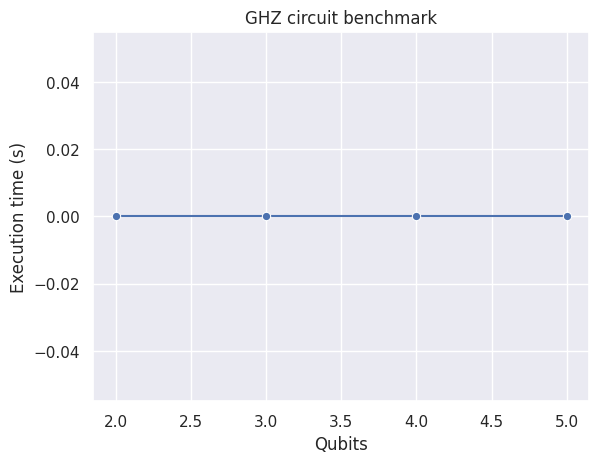

In [3]:
sns.lineplot(data=cli_df, x="qubits", y="avg_time", marker="o")
plt.title("GHZ circuit benchmark")
plt.xlabel("Qubits")
plt.ylabel("Execution time (s)")
plt.show()

In [ ]:
# Compute peak memory per backend
peak_memory = cli_df.groupby('framework')['avg_run_peak_memory'].max()
peak_memory.to_frame(name='peak_run_memory_bytes')

In [ ]:
# Plot execution time and peak memory
fig, ax1 = plt.subplots()
sns.lineplot(data=cli_df, x='qubits', y='avg_time', hue='framework', marker='o', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=cli_df, x='qubits', y='avg_run_peak_memory', hue='framework', marker='s', linestyle='--', ax=ax2)
ax1.set_xlabel('Qubits')
ax1.set_ylabel('Execution time (s)')
ax2.set_ylabel('Peak memory (bytes)')
ax1.set_title('Runtime and peak memory by backend')
plt.show()

The dashed lines above show the peak memory consumed by each backend during the benchmark run.\nComparing memory usage with execution time highlights trade-offs: a backend may execute faster but consume more memory.\nUse these metrics to choose a backend that fits both runtime and memory constraints.

/root/.pyenv/versions/3.12.10/lib/python3.12/site-packages/seaborn/axisgrid.py:44: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set(**kwargs)


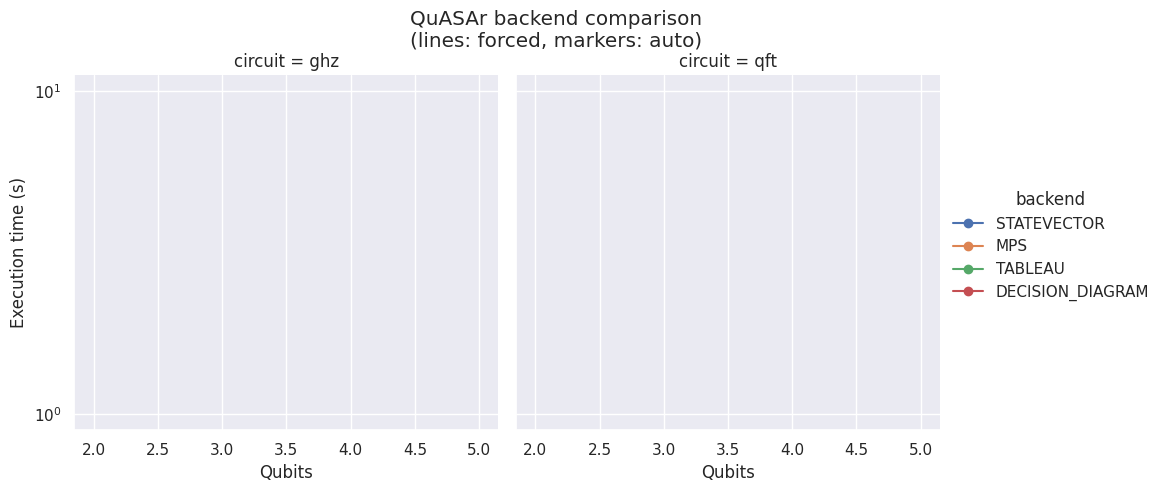

In [4]:

nb_root = Path('..').resolve()
sys.path.append(str(nb_root))
sys.path.append(str(nb_root.parent))

from runner import BenchmarkRunner
import circuits as circuit_lib
from quasar import SimulationEngine
from quasar.cost import Backend

if not hasattr(Backend, 'MQT_DD'):
    Backend.MQT_DD = Backend.DECISION_DIAGRAM

backends = [Backend.STATEVECTOR, Backend.MPS, Backend.TABLEAU, Backend.MQT_DD]
runner = BenchmarkRunner()
engine = SimulationEngine()

circuits = {
    'ghz': circuit_lib.ghz_circuit,
    'qft': circuit_lib.qft_circuit,
}

qubit_sizes = list(range(2, 6))

for name, build in circuits.items():
    for n in qubit_sizes:
        try:
            circ = build(n)
        except Exception:
            continue
        for b in backends:
            try:
                rec = runner.run_quasar_multiple(circ, engine, backend=b, repetitions=3)
                rec.update({'circuit': name, 'qubits': n, 'mode': 'forced'})
            except Exception:
                pass
        try:
            rec = runner.run_quasar_multiple(circ, engine, repetitions=3)
            rec.update({'circuit': name, 'qubits': n, 'mode': 'auto'})
        except Exception:
            pass

df = pd.DataFrame(runner.results)
results = df
backend_order = [b.name for b in backends]
palette = dict(zip(backend_order, sns.color_palette(n_colors=len(backend_order))))

forced = df[df['mode'] == 'forced']
auto = df[df['mode'] == 'auto']

g = sns.relplot(
    data=forced,
    x='qubits',
    y='run_time_mean',
    hue='backend',
    hue_order=backend_order,
    palette=palette,
    col='circuit',
    kind='line',
    marker='o',
)
g.set_axis_labels('Qubits', 'Execution time (s)')

for circuit_name, ax in g.axes_dict.items():
    sub = auto[auto['circuit'] == circuit_name]
    sns.scatterplot(
        data=sub,
        x='qubits',
        y='run_time_mean',
        hue='backend',
        hue_order=backend_order,
        palette=palette,
        marker='X',
        s=100,
        edgecolor='black',
        ax=ax,
        legend=False,
    )

g.set(yscale='log')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('QuASAr backend comparison\n(lines: forced, markers: auto)')
plt.show()

These results separate the **preparation** time from the actual **simulation** run time. Preparation typically includes converting circuits or planning steps, whereas simulation measures the time spent executing the circuit. The table and plot above illustrate how both components contribute to the total runtime.

In [5]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [6]:
# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f'../results/{nb_name}_params.json', 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f'../results/{nb_name}_results.json', 'w') as f:
            json.dump(results, f, indent=2)
    except TypeError:
        pass
